In [1]:
using MAT
using Glob
using PyCall
using PyPlot
using Random
using Eirene
using StatsBase
using Statistics
using Distributions
using DelimitedFiles

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8020519507329042907\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6767172352708530553\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8020519507329042907\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

#### Helper functions for rejection sampling

In [2]:
function rejection_sample_mvn(num_samples, mu, sigma, current_samples, distance)
    
    i = 1
    rejectcount = 0
    distribution = MvNormal(vec(mu), vec(sigma))
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 1000)
        reset = false
        sample = rand(distribution, 1)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true; 
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            sample = transpose(sample)
            totalsample = vcat(totalsample, sample)
            i += 1
        end
    end
    
    if(rejectcount > 1000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end;

function rejection_sample_uniform(num_samples, a, b, current_samples, distance)
    
    i = 1
    rejectcount = 0
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 1000)
        reset = false
        sample = rand(Uniform(a,b), 1, 2)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            totalsample = vcat(totalsample, sample)
            i += 1
        end

    end
    
    if(rejectcount > 1000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end;

#### Simulate cell sorting configurations

In [3]:
function generate_complete_sorting(num_red, num_green, num_r_cluster, num_g_cluster, seed)
    
    Random.seed!(seed)
    
    partitionsr = sample(1:num_red, num_r_cluster - 1, replace = false)
    partitionsr = sort(partitionsr)
    partitionsg = sample(1:num_green, num_g_cluster - 1, replace = false)
    partitionsg = sort(partitionsg)
    
    # place 'red' labelled cells
    amountperclusterr = []
    push!(amountperclusterr, partitionsr[1])
    for j in 2:(num_r_cluster - 1)
        push!(amountperclusterr, partitionsr[j] - partitionsr[j-1]);
    end
    push!(amountperclusterr, num_red - partitionsr[num_r_cluster-1])
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(num_red, 1)
    for i in 1:num_r_cluster
        clustercenter = rand(Uniform(-9, 9), 1, 2)
        sigma = rand(Uniform(0.25, 0.5), 1, 2)
        cellpos = rejection_sample_mvn(amountperclusterr[i], clustercenter, sigma, cellpos, 0.05)
    end
    
    # place 'green' labelled cells
    amountperclusterg = []
    push!(amountperclusterg, partitionsg[1])
    for j in 2:(num_g_cluster - 1)
        push!(amountperclusterg, partitionsg[j] - partitionsg[j-1])
    end
    push!(amountperclusterg, num_green - partitionsg[num_g_cluster-1])
    for i in 1:num_g_cluster
        clustercenter = rand(Uniform(-9, 9), 1, 2)
        sigma = rand(Uniform(0.25, 0.5), 1, 2)
        cellpos = rejection_sample_mvn(amountperclusterg[i], clustercenter, sigma, cellpos, 0.05)
    end
    celltypes = vcat(celltypes, (ones(num_green, 1) + ones(num_green, 1)))
    
    posfile = matopen("complete_sorting_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("complete_sorting_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function generate_engulfment(num_red, num_green, num_g_cluster, seed)
    
    Random.seed!(seed)
    
    # By default 'red' cells are engulfed by 'green' cells
    
    amountperclusterg = []
    largeclustercenter = rand(Uniform(-1, 1), 1, 2)
    largeclustersigma = rand(Uniform(1.5, 2.5), 1, 2)
    
    if(num_g_cluster > 1)
        partitionsg = sample(1:num_green, num_g_cluster - 1, replace = false)
        partitionsg = sort(partitionsg)
        push!(amountperclusterg, partitionsg[1])
        for j in 2:(num_g_cluster - 1)
            push!(amountperclusterg, partitionsg[j] - partitionsg[j-1]);
        end
        push!(amountperclusterg, num_green - partitionsg[num_g_cluster-1])
        
    else
        push!(amountperclusterg, num_green);
    end
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(num_green, 1)
    for i in 1:num_g_cluster
        # restrict cluster center within larger 'green' cell cluster
        clustercenter = [rand(Uniform(largeclustercenter[1] - largeclustersigma[1], 
                    largeclustercenter[1] + largeclustersigma[1])), 
            rand(Uniform(largeclustercenter[2] - largeclustersigma[2],
                    largeclustercenter[2] + largeclustersigma[2]))]
        sigma = rand(Uniform(0.1, 0.5), 1, 2)
        cellpos = rejection_sample_mvn(amountperclusterg[i], clustercenter, sigma, cellpos, 0.05)
    end
    
    rcell = Array{Float64}(undef, 0, 2)
    # sample locations for placing 'red' labelled cells
    j = 1
    distribution = MvNormal(vec(largeclustercenter), vec(largeclustersigma))
    rejectioncount = 0
    while(j <= num_red && rejectioncount <= 2000)
        currentcell = rand(distribution, 1)
        currentcell = transpose(currentcell)
        reset = false
        count = 0
        for k in 1:num_green
            dist = sqrt((cellpos[k,1] - currentcell[1])^2 + (cellpos[k,2] - currentcell[2])^2)
            if(dist <= 0.2)
                count += 1
            end
            if(count >= 10)
                reset = true
                break
            end
        end
        for l in 1:(j-1)
            dist = sqrt((rcell[l,1] - currentcell[1])^2 + (rcell[l,2] - currentcell[2])^2)
            if(dist <= 0.05)
                reset = true
                rejectioncount += 1
                break
            end
        end
        if (reset)
            j -= 1
            rejectioncount += 1
        else
            rcell = vcat(rcell, currentcell)
        end
        j += 1
        if (rejectioncount > 2000)
            write(stderr, "WARNING: Exceeded threshold for max. rejections")
            break
        end
    end
    
    cellpos = vcat(rcell, cellpos)
    celltypes = ones(num_red)
    celltypes = vcat(celltypes, ones(num_green, 1) + ones(num_green, 1))
    
    posfile = matopen("engulfment_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("engulfment_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function generate_checkerboard(num_green, num_red, num_rows, num_cols, seed)
    
    Random.seed!(seed);
    
    num_cluster = (num_rows * num_cols) ÷ 2;
    partitionsg = sample(1:num_green, num_cluster - 1, replace = false)
    partitionsg = sort(partitionsg)
    partitionsr = sample(1:num_red, num_cluster - 1, replace = false)
    partitionsr = sort(partitionsr)
    
    amountperclusterg = []
    push!(amountperclusterg, partitionsg[1])
    for j in 2:(num_cluster - 1)
        push!(amountperclusterg, partitionsg[j] - partitionsg[j-1])
    end
    push!(amountperclusterg, num_green - partitionsg[num_cluster-1])
    
    amountperclusterr = []
    push!(amountperclusterr, partitionsr[1])
    for j in 2:(num_cluster - 1)
        push!(amountperclusterr, partitionsr[j] - partitionsr[j-1])
    end
    push!(amountperclusterr, num_red - partitionsr[num_cluster-1])
    
    checkertopleft = rand(Uniform(-8, -5), 1, 2)
    checkerspacing = rand(Uniform(0.5, 1.0))
    
    # select cell type for top-left corner
    redvsgreen = rand((0,1))
    redcellpos = Array{Float64}(undef, 0, 2)
    greencellpos = Array{Float64}(undef, 0, 2)
    redcount = 1
    greencount = 1
    
    for i in 1:num_rows
        for j in 1:num_cols
            
            parity = iseven(i + j)
            minigausscenter = [checkertopleft[1] + i*checkerspacing, checkertopleft[2] + j*checkerspacing]
            
            if (redvsgreen == 1)
                if (parity)
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterg[greencount]))/10 + 0.05001), 1, 2)
                    greencellpos = rejection_sample_mvn(amountperclusterg[greencount], minigausscenter, 
                        sigma, greencellpos, 0.05)
                    greencount += 1
                else
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterr[redcount]))/10 + 0.05001), 1, 2)
                    redcellpos = rejection_sample_mvn(amountperclusterr[redcount], minigausscenter, 
                        sigma, redcellpos, 0.05)
                    redcount += 1
                end
            else
                if (parity)
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterr[redcount]))/10 + 0.05001), 1, 2)
                    redcellpos = rejection_sample_mvn(amountperclusterr[redcount], minigausscenter, 
                        sigma, redcellpos, 0.05)                 
                    redcount += 1
                else
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterg[greencount]))/10 + 0.05001), 1, 2)
                    greencellpos = rejection_sample_mvn(amountperclusterg[greencount], minigausscenter, 
                        sigma, greencellpos, 0.05)
                    greencount += 1
                end
            end
            
        end
    end
    
    cellpos = vcat(redcellpos, greencellpos)
    celltypes = ones(num_red, 1)
    celltypes = vcat(celltypes, (ones(num_green, 1) + ones(num_green, 1)))
    
    posfile = matopen("checkerboard_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("checkerboard_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function generate_isolated_cells(num_red, num_green, seed)
    
    Random.seed!(seed)
    
    cellpos = Array{Float64}(undef, 0, 2)
    cellpos = rejection_sample_uniform(num_red, -9.5, 9.5, cellpos, 0.5)
    cellpos = rejection_sample_uniform(num_green, -9.5, 9.5, cellpos, 0.5)
    celltypes = ones(num_red, 1)
    celltypes = vcat(celltypes, (ones(num_green,1) + ones(num_green,1)))
    
    posfile = matopen("isolated_cells_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("isolated_cells_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "red")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "green")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

#### Tests

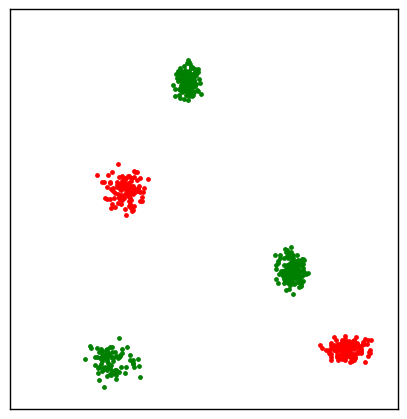

In [4]:
(cell_pos, cell_types) = generate_complete_sorting(250, 350, 2, 4, 67)
plot_syn_data(cell_pos, cell_types);

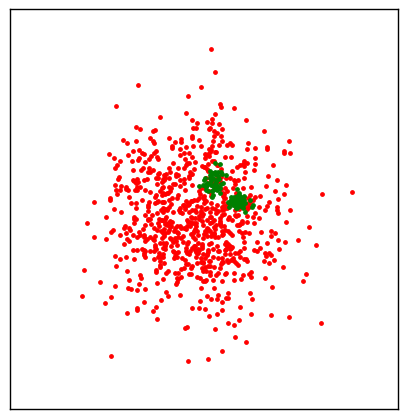

In [5]:
cellpos, celltypes = generate_engulfment(800, 100, 2, 79)
plot_syn_data(cellpos, celltypes);

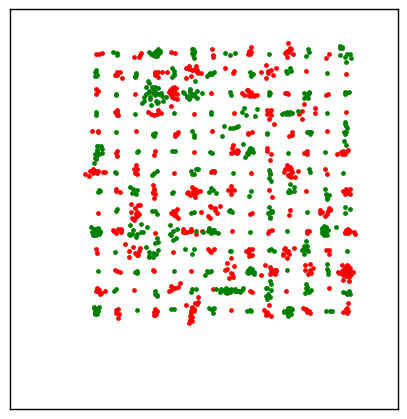

In [6]:
(cell_pos, cell_types) = generate_checkerboard(500, 500, 14, 14, 83)
plot_syn_data(cell_pos, cell_types);

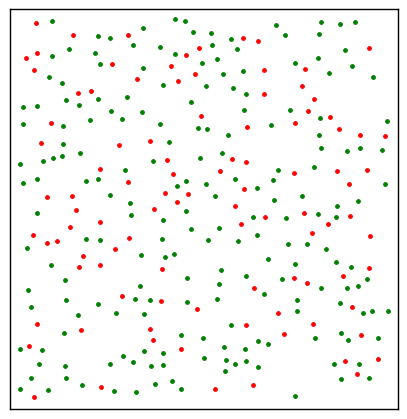

In [7]:
(cell_pos, cell_types) = generate_isolated_cells(100, 200, 89)
plot_syn_data(cell_pos, cell_types);